In [1]:
## Keras for deep learning
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.layers import Bidirectional
from keras.models import Sequential

## Scikit learn for mapping metrics
from sklearn.metrics import mean_squared_error

#for logging
import time

##matrix math
import numpy as np
import math

##plotting
import matplotlib.pyplot as plt

##data processing
import pandas as pd

In [2]:
def load_data(filename, sequence_length):
    
    #Read the data file
    raw_data = pd.read_csv(filename, dtype = float).values
    
    #Change all zeros to the number before the zero occurs
    for x in range(0, raw_data.shape[0]):
        for y in range(0, raw_data.shape[1]):
            if(raw_data[x][y] == 0):
                raw_data[x][y] = raw_data[x-1][y]
    
    #Convert the file to a list
    data = raw_data.tolist()
    
    #Convert the data to a 3D array (a x b x c) 
    #Where a is the number of days, b is the window size, and c is the number of features in the data file
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    
    #Normalizing data by going through each window
    #Every value in the window is divided by the first value in the window, and then 1 is subtracted
    d0 = np.array(result)
    dr = np.zeros_like(d0)
    dr[:,1:,:] = d0[:,1:,:] / d0[:,0:1,:] - 1
    
    #Keeping the unnormalized prices for Y_test
    #Useful when graphing bitcoin price over time later
    start = 2400
    end = int(dr.shape[0] + 1)
    unnormalized_bases = d0[start:end,0:1,20]
    
    #Splitting data set into training (First 90% of data points) and testing data (last 10% of data points)
    split_line = round(0.9 * dr.shape[0])
    training_data = dr[:int(split_line), :]
    
    #Shuffle the data
    np.random.shuffle(training_data)
    
    #Training Data
    X_train = training_data[:, :-1]
    Y_train = training_data[:, -1]
    Y_train = Y_train[:, 20]
    
    #Testing data
    X_test = dr[int(split_line):, :-1]
    Y_test = dr[int(split_line):, 49, :]
    Y_test = Y_test[:, 20]

    #Get the day before Y_test's price
    Y_daybefore = dr[int(split_line):, 48, :]
    Y_daybefore = Y_daybefore[:, 20]
    
    #Get window size and sequence length
    sequence_length = sequence_length
    window_size = sequence_length - 1 #because the last value is reserved as the y value
    
    return X_train, Y_train, X_test, Y_test, Y_daybefore, unnormalized_bases, window_size

In [3]:
def initialize_model(window_size, dropout_value, activation_function, loss_function, optimizer):
    
    #Create a Sequential model using Keras
    model = Sequential()

    #First recurrent layer with dropout
    model.add(Bidirectional(LSTM(window_size, return_sequences=True), input_shape=(window_size, X_train.shape[-1]),))
    model.add(Dropout(dropout_value))

    #Second recurrent layer with dropout
    model.add(Bidirectional(LSTM((window_size*2), return_sequences=True)))
    model.add(Dropout(dropout_value))

    #Third recurrent layer
    model.add(Bidirectional(LSTM(window_size, return_sequences=False)))

    #Output layer (returns the predicted value)
    model.add(Dense(units=1))
    
    #Set activation function
    model.add(Activation(activation_function))

    #Set loss function and optimizer
    model.compile(loss=loss_function, optimizer=optimizer)
    
    return model

In [4]:
def fit_model(model, X_train, Y_train, batch_num, num_epoch, val_split):
    
    #Record the time the model starts training
    start = time.time()

    #Train the model on X_train and Y_train
    model.fit(X_train, Y_train, batch_size= batch_num, epochs=num_epoch, validation_split= val_split)

    #Get the time it took to train the model (in seconds)
    training_time = int(math.floor(time.time() - start))
    return model, training_time

In [5]:
def test_model(model, X_test, Y_test, unnormalized_bases):
    
    #Test the model on X_Test
    y_predict = model.predict(X_test)

    #Create empty 2D arrays to store unnormalized values
    real_y_test = np.zeros_like(Y_test)
    real_y_predict = np.zeros_like(y_predict)

    #Fill the 2D arrays with the real value and the predicted value by reversing the normalization process
    for i in range(Y_test.shape[0]):
        y = Y_test[i]
        predict = y_predict[i]
        real_y_test[i] = (y+1)*unnormalized_bases[i]
        real_y_predict[i] = (predict+1)*unnormalized_bases[i]

    #Plot of the predicted prices versus the real prices
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(111)
    ax.set_title("Bitcoin Price Over Time")
    plt.plot(real_y_predict, color = 'green', label = 'Predicted Price')
    plt.plot(real_y_test, color = 'red', label = 'Real Price')
    ax.set_ylabel("Price (USD)")
    ax.set_xlabel("Time (Days)")
    ax.legend()
    
    return y_predict, real_y_test, real_y_predict, fig

In [6]:
def price_change(Y_daybefore, Y_test, y_predict):
    
    #Reshaping Y_daybefore and Y_test
    Y_daybefore = np.reshape(Y_daybefore, (-1, 1))
    Y_test = np.reshape(Y_test, (-1, 1))

    #The difference between each predicted value and the value from the day before
    delta_predict = (y_predict - Y_daybefore) / (1+Y_daybefore)

    #The difference between each true value and the value from the day before
    delta_real = (Y_test - Y_daybefore) / (1+Y_daybefore)

    #Plotting the predicted percent change versus the real percent change
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111)
    ax.set_title("Percent Change in Bitcoin Price Per Day")
    plt.plot(delta_predict, color='green', label = 'Predicted Percent Change')
    plt.plot(delta_real, color='red', label = 'Real Percent Change')
    plt.ylabel("Percent Change")
    plt.xlabel("Time (Days)")
    ax.legend()
    plt.show()
    
    return Y_daybefore, Y_test, delta_predict, delta_real, fig

In [7]:
def binary_price(delta_predict, delta_real):
    
     #Empty arrays where a 1 represents an increase in price and a 0 represents a decrease in price
    delta_predict_1_0 = np.empty(delta_predict.shape)
    delta_real_1_0 = np.empty(delta_real.shape)

    #If the change in price is greater than zero, store it as a 1
    #If the change in price is less than zero, store it as a 0
    for i in range(delta_predict.shape[0]):
        if delta_predict[i][0] > 0:
            delta_predict_1_0[i][0] = 1
        else:
            delta_predict_1_0[i][0] = 0
    for i in range(delta_real.shape[0]):
        if delta_real[i][0] > 0:
            delta_real_1_0[i][0] = 1
        else:
            delta_real_1_0[i][0] = 0    

    return delta_predict_1_0, delta_real_1_0

In [8]:
def find_positives_negatives(delta_predict_1_0, delta_real_1_0):
    
    #Finding the number of false positive/negatives and true positives/negatives
    true_pos = 0
    false_pos = 0
    true_neg = 0
    false_neg = 0
    for i in range(delta_real_1_0.shape[0]):
        real = delta_real_1_0[i][0]
        predicted = delta_predict_1_0[i][0]
        if real == 1:
            if predicted == 1:
                true_pos += 1
            else:
                false_neg += 1
        elif real == 0:
            if predicted == 0:
                true_neg += 1
            else:
                false_pos += 1
    return true_pos, false_pos, true_neg, false_neg

In [9]:
def calculate_statistics(true_pos, false_pos, true_neg, false_neg, y_predict, Y_test):
    
    precision = float(true_pos) / (true_pos + false_pos)
    recall = float(true_pos) / (true_pos + false_neg)
    F1 = float(2 * precision * recall) / (precision + recall)
    #Get Mean Squared Error
    MSE = mean_squared_error(y_predict.flatten(), Y_test.flatten())

    return precision, recall, F1, MSE

In [10]:
X_train, Y_train, X_test, Y_test, Y_daybefore, unnormalized_bases, window_size = load_data("D:\s9\data_mining\FINAL_PROJECT\Bitcoin_Data.csv", 50)


In [11]:
print(X_train.shape)
print(Y_train.shape)

(2988, 49, 37)
(2988,)


In [12]:
print(X_test.shape)
print(Y_test.shape)

(332, 49, 37)
(332,)


In [13]:
print(Y_daybefore.shape)
print(unnormalized_bases.shape)
print(window_size)

(332,)
(920, 1)
49


In [14]:
model = initialize_model(window_size, 0.2, 'linear', 'mse', 'adam')
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 49, 98)           34104     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 49, 98)            0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 49, 196)          154448    
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 49, 196)           0         
                                                                 
 bidirectional_2 (Bidirectio  (None, 98)               96432     
 nal)                                                            
                                                        

In [15]:
model, training_time = fit_model(model, X_train, Y_train, 1600, 150, .05)

#Print the training time
print("Training time", training_time, "seconds")

Epoch 1/150
2/2 [==============================] - 56s 21s/step - loss: 2.4214 - val_loss: 2.2192
Epoch 2/150
2/2 [==============================] - 24s 11s/step - loss: 1.8876 - val_loss: 1.9079
Epoch 3/150
2/2 [==============================] - 27s 14s/step - loss: 1.5369 - val_loss: 1.7593
Epoch 4/150
2/2 [==============================] - 24s 12s/step - loss: 1.3493 - val_loss: 1.5823
Epoch 5/150
2/2 [==============================] - 24s 11s/step - loss: 1.1983 - val_loss: 1.4143
Epoch 6/150
2/2 [==============================] - 25s 12s/step - loss: 1.0623 - val_loss: 1.2769
Epoch 7/150
2/2 [==============================] - 25s 12s/step - loss: 0.9547 - val_loss: 1.1253
Epoch 8/150
2/2 [==============================] - 26s 13s/step - loss: 0.8258 - val_loss: 1.0006
Epoch 9/150
2/2 [==============================] - 25s 12s/step - loss: 0.7540 - val_loss: 0.8919
Epoch 10/150
2/2 [==============================] - 26s 12s/step - loss: 0.6535 - val_loss: 0.7992
Epoch 11/150
2/2 [=

Epoch 84/150
2/2 [==============================] - 38s 18s/step - loss: 0.0343 - val_loss: 0.3750
Epoch 85/150
2/2 [==============================] - 36s 17s/step - loss: 0.0334 - val_loss: 0.3671
Epoch 86/150
2/2 [==============================] - 36s 16s/step - loss: 0.0332 - val_loss: 0.3664
Epoch 87/150
2/2 [==============================] - 39s 18s/step - loss: 0.0331 - val_loss: 0.3451
Epoch 88/150
2/2 [==============================] - 37s 17s/step - loss: 0.0337 - val_loss: 0.3422
Epoch 89/150
2/2 [==============================] - 37s 18s/step - loss: 0.0309 - val_loss: 0.3603
Epoch 90/150
2/2 [==============================] - 37s 17s/step - loss: 0.0306 - val_loss: 0.3386
Epoch 91/150
2/2 [==============================] - 39s 18s/step - loss: 0.0300 - val_loss: 0.3733
Epoch 92/150
2/2 [==============================] - 36s 17s/step - loss: 0.0331 - val_loss: 0.3453
Epoch 93/150
2/2 [==============================] - 38s 17s/step - loss: 0.0297 - val_loss: 0.3180
Epoch 94/1

In [16]:
model.save("D:\s9\data_mining\FINAL_PROJECT\ourmodel.h5")


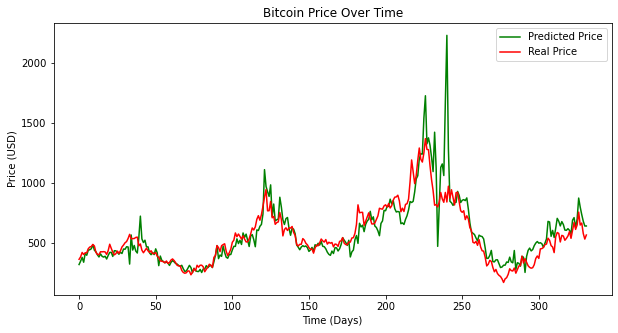

In [17]:
y_predict, real_y_test, real_y_predict, fig1 = test_model(model, X_test, Y_test, unnormalized_bases)

#Show the plot
plt.show(fig1)

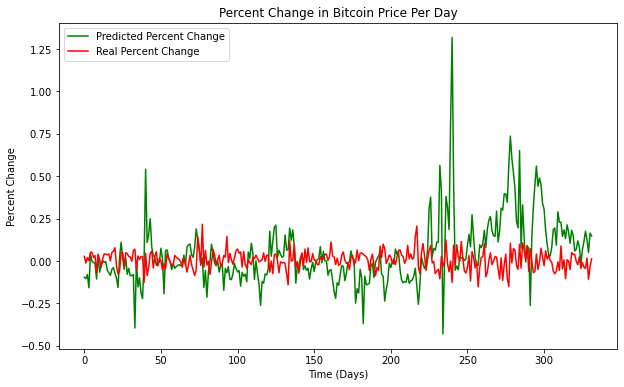

In [18]:
Y_daybefore, Y_test, delta_predict, delta_real, fig2 = price_change(Y_daybefore, Y_test, y_predict)

#Show the plot
plt.show(fig2)

In [19]:
delta_predict_1_0, delta_real_1_0 = binary_price(delta_predict, delta_real)

print(delta_predict_1_0.shape)
print(delta_real_1_0.shape)

(332, 1)
(332, 1)


In [20]:
true_pos, false_pos, true_neg, false_neg = find_positives_negatives(delta_predict_1_0, delta_real_1_0)
print("True positives:", true_pos)
print("False positives:", false_pos)
print("True negatives:", true_neg)
print("False negatives:", false_neg)

True positives: 84
False positives: 32
True negatives: 45
False negatives: 39


In [21]:
precision, recall, F1, MSE = calculate_statistics(true_pos, false_pos, true_neg, false_neg, y_predict, Y_test)
print("Precision:", precision)


Precision: 0.7241379310344828


In [22]:
print("Recall:", recall)
print("F1 score:", F1)
print("Mean Squared Error:", MSE)

Recall: 0.6829268292682927
F1 score: 0.7029288702928871
Mean Squared Error: 0.10651596577361128
